In [1]:
!rm -rf cv-image-classification
!git clone https://github.com/AlexFerroni02/cv-image-classification.git

Cloning into 'cv-image-classification'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
Receiving objects: 100% (11/11), 41.34 KiB | 41.34 MiB/s, done.
remote: Total 11 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)


In [2]:
import sys
sys.path.append("/content/cv-image-classification")

# Training Pipeline — Baseline CNN

This notebook implements the training and evaluation pipeline for the
baseline CNN model designed in the previous step.

The goal is to:
- Train the model in a reproducible way
- Establish a reliable baseline performance
- Collect metrics for future comparisons


In [3]:
# PyTorch core libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Dataset and data loading utilities
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Utilities
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt


In [4]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


Reproducibility is a critical aspect of machine learning experiments.
Setting seeds ensures that results can be consistently reproduced.


In [5]:
# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [6]:
# Basic transformation: convert images to tensors
# No data augmentation is applied at this stage
transform = transforms.ToTensor()

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170M/170M [00:19<00:00, 8.92MB/s]


In [7]:
# DataLoader handles batching and shuffling
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)


Batching improves training stability and computational efficiency.
Shuffling the training data prevents the model from learning spurious order-based patterns.


In [8]:
import sys
sys.path.append("/content/cv-image-classification")

# Import the model from the architecture notebook / src
from src.model import SimpleCNN

# Initialize model and move it to the selected device
model = SimpleCNN(num_classes=10).to(device)

In [9]:
# Cross-entropy loss is standard for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer provides adaptive learning rates
optimizer = optim.Adam(model.parameters(), lr=1e-3)


CrossEntropyLoss combines softmax and negative log-likelihood.
Adam is chosen for its stability and fast convergence on baseline models.


In [10]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy


In [11]:
def evaluate(model, dataloader, criterion, device):
    """
    Evaluate the model on the validation/test set.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy


In [12]:
num_epochs = 10

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    test_loss, test_acc = evaluate(
        model, test_loader, criterion, device
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}"
    )


100%|██████████| 782/782 [00:09<00:00, 78.78it/s]


Epoch [1/10] Train Loss: 1.4787, Train Acc: 0.4661 | Test Loss: 1.1995, Test Acc: 0.5743


100%|██████████| 782/782 [00:08<00:00, 87.66it/s]


Epoch [2/10] Train Loss: 1.1134, Train Acc: 0.6059 | Test Loss: 1.0229, Test Acc: 0.6383


100%|██████████| 782/782 [00:09<00:00, 80.76it/s]


Epoch [3/10] Train Loss: 0.9530, Train Acc: 0.6643 | Test Loss: 0.9880, Test Acc: 0.6546


100%|██████████| 782/782 [00:09<00:00, 83.56it/s]


Epoch [4/10] Train Loss: 0.8493, Train Acc: 0.7028 | Test Loss: 0.9196, Test Acc: 0.6839


100%|██████████| 782/782 [00:09<00:00, 83.82it/s]


Epoch [5/10] Train Loss: 0.7729, Train Acc: 0.7291 | Test Loss: 0.9141, Test Acc: 0.6888


100%|██████████| 782/782 [00:09<00:00, 83.55it/s]


Epoch [6/10] Train Loss: 0.6955, Train Acc: 0.7576 | Test Loss: 0.8512, Test Acc: 0.7061


100%|██████████| 782/782 [00:08<00:00, 87.62it/s]


Epoch [7/10] Train Loss: 0.6385, Train Acc: 0.7767 | Test Loss: 0.8358, Test Acc: 0.7163


100%|██████████| 782/782 [00:08<00:00, 92.38it/s]


Epoch [8/10] Train Loss: 0.5760, Train Acc: 0.7975 | Test Loss: 0.8814, Test Acc: 0.7094


100%|██████████| 782/782 [00:09<00:00, 85.77it/s]


Epoch [9/10] Train Loss: 0.5237, Train Acc: 0.8167 | Test Loss: 0.8956, Test Acc: 0.7030


100%|██████████| 782/782 [00:09<00:00, 83.14it/s]


Epoch [10/10] Train Loss: 0.4738, Train Acc: 0.8344 | Test Loss: 0.8944, Test Acc: 0.7224


## Training Behavior

During training, we monitor both loss and accuracy on:
- Training set
- Test set

This allows us to:
- Detect underfitting or overfitting
- Establish a baseline performance level


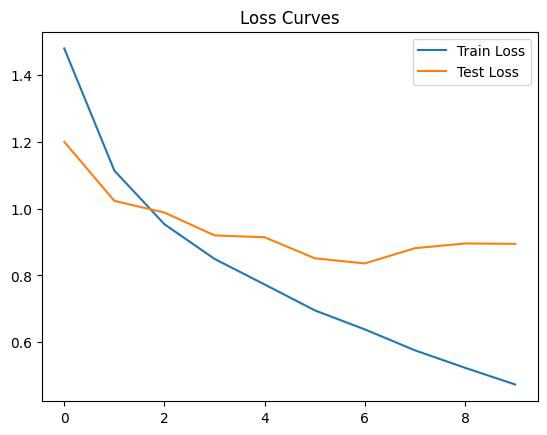

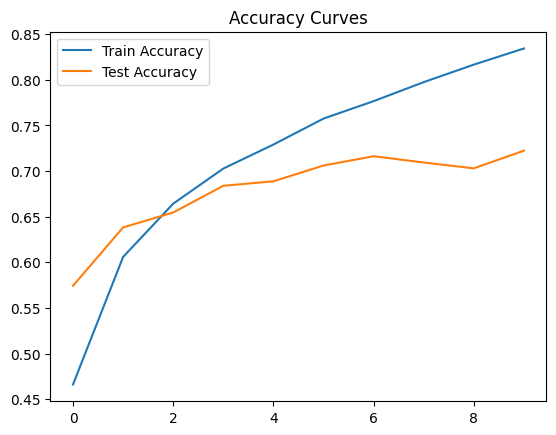

In [13]:
# Plot loss curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

# Plot accuracy curves
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()


## Baseline Training Conclusions

The baseline CNN is able to learn meaningful visual representations
and achieves performance significantly above random chance.

The learning curves indicate:
- Stable optimization
- No severe overfitting at this stage

This baseline will serve as a reference point for future improvements,
including data augmentation, regularization, and architectural enhancements.


In [16]:
import os

# Define the base directory for saving results
results_dir = "/content/cv-image-classification/results"

# Create the results directory if it doesn't exist
os.makedirs(results_dir, exist_ok=True)

torch.save(model.state_dict(), os.path.join(results_dir, "baseline_model.pth"))